### Метрики качества классификации.

Сегодня мы научимся использовать различные метрики для оценки качества моделей.

Для начала загрузим данные с предыдущей домашней задачи с небольшим `сюрпризом`. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("processed_train.csv")

In [3]:
data.head()

,EngineVersion,AppVersion,AvSigVersion,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,...,Platform_windows8,Processor_x64,Processor_x86,Census_DeviceFamily_Windows.Server,Census_OSArchitecture_arm64,Census_OSArchitecture_x86,Census_GenuineStateName_IS_GENUINE,Census_GenuineStateName_OFFLINE,Census_GenuineStateName_UNKNOWN,HasDetections
0,0.552153,0.530941,0.587952,7.0,0,53447.0,1.0,1.0,1,29,...,0,1,0,0,0,0,1,0,0,0
1,0.448751,0.528931,0.484434,7.0,0,53447.0,1.0,1.0,1,93,...,0,1,0,0,0,0,0,1,0,0
2,0.552153,0.530941,0.557522,7.0,0,53447.0,1.0,1.0,1,86,...,0,1,0,0,0,0,1,0,0,0
3,0.552153,0.530941,0.482759,7.0,0,53447.0,1.0,1.0,1,97,...,0,1,0,0,0,0,1,0,0,0
4,0.493175,0.530941,0.505721,7.0,0,53447.0,1.0,1.0,1,164,...,0,1,0,0,0,0,1,0,0,0


Один из гномов очень завидовал своим братьям, переплюнувшим его по `accuracy` в бонусном задании предыдущей домашней работы. Поэтому совершил следующее злодеяние: выкинул кучу объектов таким образом, чтобы баланс классов нарушился! 

`Может, accuracy у них станет еще больше, зато преподаватель их отругает, ведь использовать accuracy при дисбалансе не очень-то хорошо!` - подумал гном

Замерьте количество объектов в порченом датафрейме.
В какой пропорции соотносятся классы теперь?

In [4]:
### Your code is here

print(f"Количество нулей: {sum(data['HasDetections'] == 0)}")
print(f"Количество единиц: {sum(data['HasDetections'] == 1)}")


Количество нулей: 99940
Количество единиц: 20012


Произведем процедуру отложенной выборки:

In [6]:
from sklearn.model_selection import train_test_split


Y = data['HasDetections']
X = data.drop('HasDetections', axis=1)

X_train, X_test, Y_train, Y_test  = train_test_split(X, Y, 
                                                     test_size=0.25, 
                                                     shuffle=True, 
                                                     random_state=1)

Обучите логистическую регрессию с параметром `l2` регуляризации `C = 0.01` на порченом датасете.
Замерьте долю верно классифицированных объектов на трейне и на тесте. Можете использовать абсолютно любые конструкции, главное не забыть пронормировать данные с помощью `StandardScaler`

In [7]:
### Your code is here

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipe = Pipeline([("scaler", StandardScaler()),
                 ("model", LogisticRegression(penalty='l2', C=0.01))])

pipe.fit(X_train, Y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('model', LogisticRegression(C=0.01))])

In [9]:
print(f"Train accuracy: {pipe.score(X_train, Y_train)}")
print(f"Test accuracy: {pipe.score(X_test, Y_test)}")

Train accuracy: 0.8412364945978391
Test accuracy: 0.8421368547418968


Кажется, что, по сравнению с результатами в предыдущей домашней работе, мы построили куда более сильную модель. Но мы сильно заблуждаемся, если в это верим!

**Задание 2.**
Для бинарной классификации можно построить так называемую **confision matrix** (матрица ошибок), которая подсчитывает количество правильных и неправильных предсказаний и разделяет их по двум классам:

|          | a(x) = -1  | a(x) = +1  |
|----------|------------|------------|
|  y = -1  |     TN     |     FP     |
|  y = +1  |     FN     |     TP     |

* Positive/Negative отражает то, к какому классу определила объект наша модель $a(x)$, в нашем случае нулевой класс соответствует Negative (нет вируса), а единичный класс - Positive (есть вирус).

* True/False просто показывает, совпало ли предсказание модели с реальным классом объекта, поэтому на главной диагонали стоят True, а на побочной False.

**2.1)** Постройте вручную матрицу ошибок на тестовой выборке, используя реальные и предсказанные вашей моделью метки классов. Потом сравните результат с методом `confusion_matrix` в `sklearn`.

In [11]:
pipe.fit(X_train, Y_train)
pred_test = pipe.predict(X_test)

In [17]:
### Your code is here

pred_test

array([0, 0, 0, ..., 0, 0, 0], shape=(29988,))

In [21]:
### Your code is here

tp = np.sum((pred_test == 1) & (Y_test == 1))
tn = np.sum((pred_test == 0) & (Y_test == 0))
fp = np.sum((pred_test == 1) & (Y_test == 0))
fn = np.sum((pred_test == 0) & (Y_test == 1))

print(f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")
print(tn, fp, fn, tp)

TP: 527, TN: 24727, FP: 292, FN: 4442
24727 292 4442 527


**2.2)** Посчитайте стандартную метрику Accuracy на тестовой выборке c помощью матрицы ошибок. Напомним, что это просто доля верно предсказанных меток:
$
ACC = \dfrac{TP + TN}{TP + TN + FP + FN}
$.

(Не стоит переводить accuracy как точность, так как под точностью иногда еще понимают precision, который является совсем другим показателем! Лучше всегда использовать английские версии метрик, чтобы не возникало недопониманий.)

In [23]:
### Your code is here

acc = (tp + tn) / (tp + tn + fp + fn)
acc

np.float64(0.8421368547418968)

Мы ожидаем, что полученная accuracy совпадет с той, что была подсчитана во время использования функции `cross_validate`

Мы знаем, что accuracy не является хорошим показателем качества модели при несбалансированных классах. 

Допустим у нас 1000 объектов, где 990 имеют метку класса 0, а остальные 10 имеют метку 1. В нашем случае, класс 0 соответствует компьютерам, на которых нет вируса, а класс 1 - на которых есть. Тогда accuracy у константной модели, которая всегда предсказывает нулевой класс будет $0.99$, хотя задача как раз состоит в том, чтобы детектировать эти самые 10 объектов, которые соответствуют зараженным компьютерам. 

При несбалансированных выборках с помощью матрицы ошибок можно посчитать следующие метрики:

* **Precision** показывает "точность" попадания нашего классификатора в положительный класс, то есть долю правильно предсказанных положительных объектов среди всех **предсказанных** положительных объектов. 

* **Recall** показывает "полноту" предсказаний нашего классификатора, то есть долю правильно предсказанных положительных объектов среди всех **реальных** положительных объектов.

**2.3)** Посчитайте Precision и Recall с помощью матрицы ошибок. Потом сравните с реализацией в sklearn. Напомним формулы из лекции:

$$
Precision = \dfrac{TP}{TP + FP}, \quad Recall = \dfrac{TP}{TP + FN}
$$

In [24]:
from sklearn.metrics import recall_score, precision_score

### Your code is here

precision = tp / (tp + fp)
recall = tp / (tp + fn)

print(f"Precision: {precision}, Recall: {recall} ручками")

precision = precision_score(Y_test, pred_test)
recall = recall_score(Y_test, pred_test)

print(f"Precision: {precision}, Recall: {recall} из sklearn")

Precision: 0.6434676434676435, Recall: 0.10605755685248541 ручками
Precision: 0.6434676434676435, Recall: 0.10605755685248541 из sklearn


Теперь картина кажется не такой уж лучезарной!

Вспомним, 

Метод `.predict` на самом деле берёт предсказанные вероятности для каждого класса и каждому объекту присваивает тот класс, у которого больше вероятность. 

Так как мы сейчас занимаемся бинарной классификацией, то большая вероятность определяется просто сравнением с порогом 0.5.

**2.4)** Воспользуйтесь методом `.predict_proba` и с помощью сравнения с порогом 0.5 постройте вектор предсказаний. Проверьте результат на ранее предсказанных метках, вектора должны совпадать.

In [28]:
### Your code is here


proba = (pipe.predict_proba(X_test)[:, 1] > 0.5).astype(int)
print(f"Predictions: {(pred_test == proba).all()}")

Predictions: True


**Задание 3.**
Решим бизнес задачу. \
**3.1)** Допустим, заказчик требует, чтобы наш классификатор в 60% случаев правильно предсказывал наличие вируса на компьютере, чтобы не беспокоить клиентов из-за ложноположительных результатов. \
Как решить эту задачу? =>
Надо подобрать порог, который максимизирует `recall` при условии, что `precision > 0.6`.

$$
(recall | precision > 0.6) \to \max_{thres}
$$

In [35]:
from sklearn.metrics import precision_recall_curve

### Строим всевозможные комбинации precision, recall, threshold

precision, recall, thres = precision_recall_curve(y_test, pipe.predict_proba(X_test)[:, 1])

### Находим такую тройку, при которой recall максимален, а precision > 0.6

ind = np.where(recall == recall[precision > 0.6].max())

print(f"Precison:\t {precision[ind][-1]}")
print(f"Recall: \t {recall[ind][-1]}")
print(f"Threshold:\t {thres[ind][-1]}") 

Precison:	 0.6003734827264239
Recall: 	 0.12940229422418997
Threshold:	 0.458948774379042


Теперь, чтобы соответствовать установленным условиям, мы будем замерять вероятности для объектов и сравнивать и с найденным `Threshold`, который решает нашу задачу

**3.2)** Аналогично решите задачу, где заказчик требует, чтобы наш классификатор находил хотя бы 20% компьютеров с вирусом, среди всех действительно зараженных компьютеров.
$$
(precision | recall > 0.2) \to \max_{thres}
$$

In [40]:
### Your code is here
ind = np.where(precision == precision[recall > 0.2].max())

print(f"Precison:\t {precision[ind][-1]}")
print(f"Recall: \t {recall[ind][-1]}")
print(f"Threshold:\t {thres[ind][-1]}") 

Precison:	 0.4928182268449728
Recall: 	 0.20024149728315557
Threshold:	 0.3312852515525588


**Задание 4.** На самом деле, можно объединить предыдущие две задачи и максимизировать взвешенную метрику, которая учитывает и Precision, и Recall. \
Посчитайте три такие метрики: среднее арифметическое, среднее геометрическое и минимум. 
1) Найдите порог, который их максимизирует. 
2) Выведите precision и recall, соответствующие этому порогу. 
3) Нарисуйте линии уровня для каждой из этих метрик, используя функцию `level_lines`. 
4) Изобразите точку $(recall, precision)$ соответствующую этому порогу на графике линий уровня.

$$
Arithm_{avg} = \dfrac{P + R}{2}, \quad Geom_{avg} = \sqrt{P \cdot R}, \quad Min = \min(P, R)
$$


In [45]:
def level_lines(func, name):
    x = np.linspace(0, 1.1, 100)
    y = np.linspace(0, 1.1, 100)
    
    X, Y = np.meshgrid(x, y)
    Z = func(X, Y)
    
    plt.figure(figsize=(5, 5))
    plt.title(name)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.contour(X, Y, Z, 15, cmap='plasma')

Precision:	 0.16993934409375963
Recall: 	 0.9979875226403703
Threshold:	 0.02191334836645265
F-measure:	 0.5839634333670649


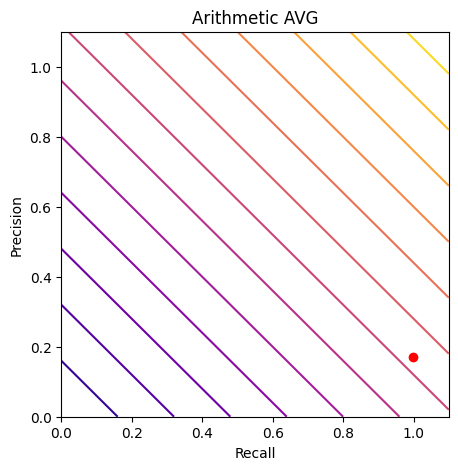

In [70]:
### Покажем на примере среднего арифметического, что должно у вас получиться

metric_func = lambda x, y: (x + y)/2

arithm_idx = (metric_func(precision, recall)).argmax()

print(f"Precision:\t {precision[arithm_idx]}")
print(f"Recall: \t {recall[arithm_idx]}")
print(f"Threshold:\t {thres[arithm_idx]}")
print(f"F-measure:\t {metric_func(precision[arithm_idx], recall[arithm_idx])}")

level_lines(metric_func, "Arithmetic AVG")
plt.plot(recall[arithm_idx], precision[arithm_idx], 'ro');

Precision:	 0.22387976621207903
Recall: 	 0.809418394043067
Threshold:	 0.12601413817366497
F-measure:	 0.42569049886756727


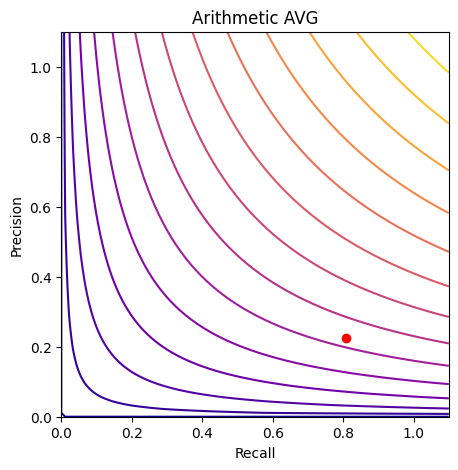

In [69]:
### Повторите для среднего геометрического
### Your code is here

metric_func = lambda x, y: (x * y)**0.5

arithm_idx = (metric_func(precision, recall)).argmax()

print(f"Precision:\t {precision[arithm_idx]}")
print(f"Recall: \t {recall[arithm_idx]}")
print(f"Threshold:\t {thres[arithm_idx]}")
print(f"F-measure:\t {metric_func(precision[arithm_idx], recall[arithm_idx])}")

level_lines(metric_func, "Arithmetic AVG")
plt.plot(recall[arithm_idx], precision[arithm_idx], 'ro');






Precision:	 0.2853228104790091
Recall: 	 0.523847856711612
Threshold:	 0.19267672583062853
F-measure:	 0.3694294635254045


C:\Users\Роман\AppData\Local\Temp\ipykernel_22660\677510902.py:4: RuntimeWarning: invalid value encountered in divide
  metric_func = lambda x, y: 2 * x * y / (x + y)


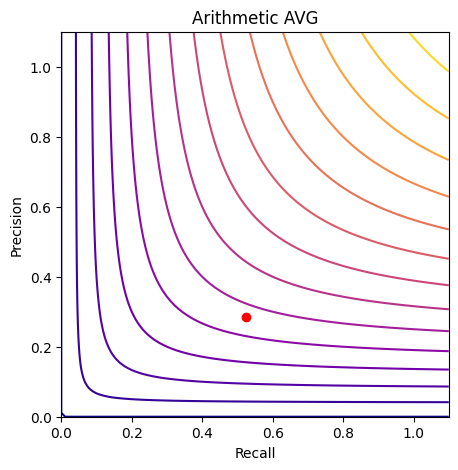

In [68]:
### Повторите для минимума
### Your code is here

metric_func = lambda x, y: 2 * x * y / (x + y)

arithm_idx = (metric_func(precision, recall)).argmax()

print(f"Precision:\t {precision[arithm_idx]}")
print(f"Recall: \t {recall[arithm_idx]}")
print(f"Threshold:\t {thres[arithm_idx]}")
print(f"F-measure:\t {metric_func(precision[arithm_idx], recall[arithm_idx])}")

level_lines(metric_func, "Arithmetic AVG")
plt.plot(recall[arithm_idx], precision[arithm_idx], 'ro');


**Задание 5.** Одним из самых распространенных показателей качества является **F-мера**, которая обобщает все вышерассмотренные метрики. Более того, в ней можно регулировать параметр $\beta^2$, который отвечает за предпочтение между precision и recall. 
$$
F = \dfrac{(1 + \beta^2) P \cdot R}{\beta^2 P + R}
$$
* При $\beta^2 = 1$ и precision, и recall нам важны в равной степени.
* При $\beta^2 > 1$ предпочтение отдается recall. Похоже на решение задачи, где мы фиксируем приемлемое для нас значение precision и максимизируем recall.
* При $0 < \beta^2 < 1$ предпочтение отдается precision. Похоже на решение задачи, где мы фиксируем приемлемое для нас значение recall и максимизируем precision.

Найдите порог, который максимизирует:
1) F-меру с $\beta^2 = 1$,
2) F-меру с $\beta^2 = 0.05$,
3) F-меру с $\beta^2 = 4$.\
Для всех трех случаев выведите precision, recall, threshold и F-меру. 
Нарисуйте линии уровня и точку, которая максимизирует F-меру по аналогии с предыдущим пунктом.

Precision:	 0.2853228104790091
Recall: 	 0.523847856711612
Threshold:	 0.19267672583062853
F-measure:	 0.3694294635254045


C:\Users\Роман\AppData\Local\Temp\ipykernel_22660\1920629739.py:7: RuntimeWarning: invalid value encountered in divide
  metric_func = lambda x, y: (1 + b) * x * y / (b * x + y)


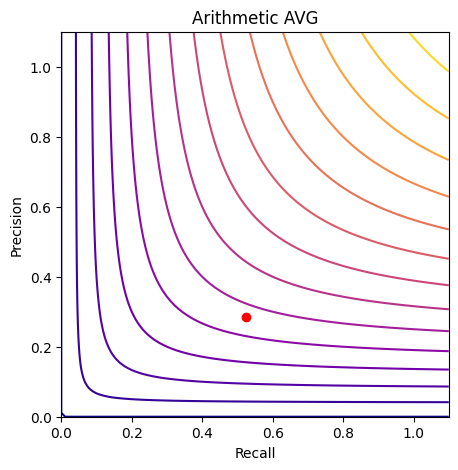

In [67]:
### Повторите для F-меры при \beta^2=1
### Выведите ее вместе с precision/recall/threshold
### Your code is here

b = 1

metric_func = lambda x, y: (1 + b) * x * y / (b * x + y)

arithm_idx = (metric_func(precision, recall)).argmax()

print(f"Precision:\t {precision[arithm_idx]}")
print(f"Recall: \t {recall[arithm_idx]}")
print(f"Threshold:\t {thres[arithm_idx]}")
print(f"F-measure:\t {metric_func(precision[arithm_idx], recall[arithm_idx])}")

level_lines(metric_func, "Arithmetic AVG")
plt.plot(recall[arithm_idx], precision[arithm_idx], 'ro');


Precision:	 0.8648648648648649
Recall: 	 0.012879855101630106
Threshold:	 0.689104906336083
F-measure:	 0.7775752842141803


C:\Users\Роман\AppData\Local\Temp\ipykernel_22660\2008400772.py:7: RuntimeWarning: invalid value encountered in divide
  metric_func = lambda x, y: (1 + b) * x * y / (b**2 * x + y)


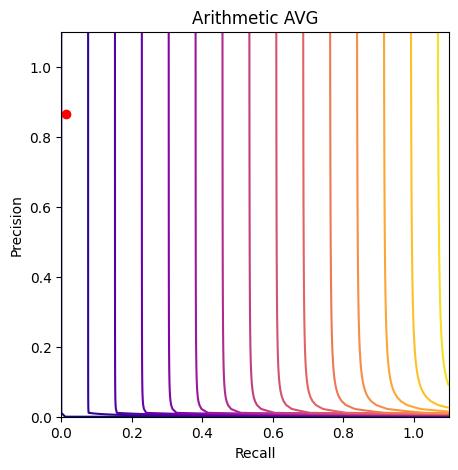

In [66]:
### Повторите для F-меры при \beta^2=0.05
### Выведите ее вместе с precision/recall/threshold
### Your code is here

b = 0.05

metric_func = lambda x, y: (1 + b) * x * y / (b**2 * x + y)

arithm_idx = (metric_func(precision, recall)).argmax()

print(f"Precision:\t {precision[arithm_idx]}")
print(f"Recall: \t {recall[arithm_idx]}")
print(f"Threshold:\t {thres[arithm_idx]}")
print(f"F-measure:\t {metric_func(precision[arithm_idx], recall[arithm_idx])}")

level_lines(metric_func, "Arithmetic AVG")
plt.plot(recall[arithm_idx], precision[arithm_idx], 'ro');


Precision:	 0.21052631578947367
Recall: 	 0.8597303280338097
Threshold:	 0.10928731456879999
F-measure:	 0.5317665803624776


C:\Users\Роман\AppData\Local\Temp\ipykernel_22660\3119721161.py:9: RuntimeWarning: invalid value encountered in divide
  metric_func = lambda x, y: (1 + b) * x * y / (b * x + y)


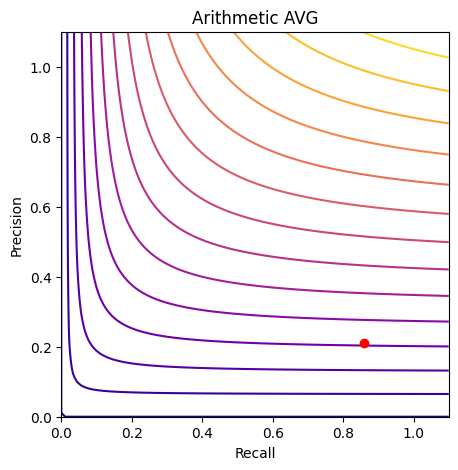

In [65]:
### Повторите для F-меры при \beta^2=4
### Выведите ее вместе с precision/recall/threshold
### Your code is here



b = 4

metric_func = lambda x, y: (1 + b) * x * y / (b * x + y)

arithm_idx = (metric_func(precision, recall)).argmax()

print(f"Precision:\t {precision[arithm_idx]}")
print(f"Recall: \t {recall[arithm_idx]}")
print(f"Threshold:\t {thres[arithm_idx]}")
print(f"F-measure:\t {metric_func(precision[arithm_idx], recall[arithm_idx])}")

level_lines(metric_func, "Arithmetic AVG")
plt.plot(recall[arithm_idx], precision[arithm_idx], 'ro');



